Hello, and welcome to the Titanic Homework!  

Christopher Cook  Machine Learning

Let's get started

In [2]:
#Import pandas and SKLearn stuff
import pandas as pd
from sklearn import ensemble
from sklearn import linear_model
from sklearn import model_selection

Let's open the data and take a look

In [3]:
#open data
train = pd.read_csv('C:/users/Christopher Cook/Downloads/kaggle/trainti.csv')

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


It looks like we can split up the cabin variable to get more information. The deck is the first letter and the room number is after it. Even numbers were on the right side of the ship so that might help predict as well.

In [5]:
#We can use the cabin number to get a better estimate of survival (for those who have it) Even numbers are on the right side 
#which is the side that was hit. We can also learn which deck they were on.
train['deck'] = train['Cabin'].astype(str).str[0]
train['even'] = train['Cabin'].str.endswith('0') + train['Cabin'].str.endswith('2') + train['Cabin'].str.endswith('4') \
                + train['Cabin'].str.endswith('6') + train['Cabin'].str.endswith('8')
train['number'] = train['Cabin'].astype(str).str[1:]
train['number'] = pd.to_numeric(train['number'],errors='coerce')

Great! I considered looking into the ticked number, but I don't think it's worth our time (as is the person's age). I don't think they would hold any predictive value. So, let's go and get rid of Nans and make dummies for class sex deck and embarkment place.

In [6]:
#Let's fill in the nans, and make dummies. Since we're using a forest we don't have to be too careful about what values we 
train = train.fillna(value={'Pclass' : 0, 'Name' : "UKN", 'Sex' : "U", 'Age' : -1, 'SibSp' : -1, 'Parch' : -1, 'Fare' : -1, \
                    'Embarked' : "Unk", 'even' : -1, 'number' : -1})
rdy_train = pd.get_dummies(train[['Pclass','Sex','Embarked','deck']])
for name in ['Survived','Age','SibSp','Parch','Fare']:
    rdy_train[name] = train[name]

Let's take a peek to make sure everything looks good

In [7]:
rdy_train.head()

,Pclass,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Embarked_Unk,deck_A,deck_B,deck_C,...,deck_E,deck_F,deck_G,deck_T,deck_n,Survived,Age,SibSp,Parch,Fare
0,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,22.0,1,0,7.2500
1,1,1,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1,38.0,1,0,71.2833
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0,0,1,1,26.0,0,0,7.9250
3,1,1,0,0,0,1,0,0,0,1,...,0,0,0,0,0,1,35.0,1,0,53.1000
4,3,0,1,0,0,1,0,0,0,0,...,0,0,0,0,1,0,35.0,0,0,8.0500


In [8]:
list(rdy_train)

['Pclass',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_Unk',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_T',
 'deck_n',
 'Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare']

Yup! Looks great. Let's start training! We're going to start with OLS to get a baseline. (I know that if I were really interested in OLS I'd have made the data differently, but that doesn't have to stop us!)

In [9]:
#OK Let's split this into X and y and get started!
X = rdy_train.drop(['Survived'], axis=1)
y = rdy_train['Survived']
#Though we will use the X and y later to train the submission model, we need a validation set
Xtrain, Xtest, Ytrain, Ytest = model_selection.train_test_split(X,y,test_size = 0.2)

In [9]:
#First we're going to run OLS to get a basline for our data.
ols = linear_model.LinearRegression(normalize=True)
ols.fit(Xtrain,Ytrain)
ols.score(Xtest,Ytest)

0.38802291217349999

So that is a pretty horrible R^2. Let's get into some forests! We're going to do Random Forest first, and then an Adaboosted forest.

In [10]:
#OK let's do a random forest!
rf = ensemble.RandomForestClassifier()
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [2,5,10], 'max_features' : [None, 'auto'] }, cv=7)
gsf.fit(Xtrain,Ytrain)
gsf.score(Xtest,Ytest)

0.79329608938547491

In [11]:
#Great! let's look at what hyperparameters we used
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))

{'max_depth': 5, 'max_features': 'auto', 'n_estimators': 1000, 'n_jobs': -1}
0.845505617978


You can see that there's some pretty bad overfitting going on. In the following cells I do some extensive hyperparameter tuning, until I find the best one is a max_depth of 4 and max_features of 1.0.

In [12]:
#OK so we're painfully overfitting. Max depth will have to go down, and num_features too.
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [2,3], 'max_features' : [0.5,0.2] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 3, 'max_features': 0.5, 'n_estimators': 1000, 'n_jobs': -1}
0.816011235955
0.804469273743


In [13]:
#Well, though our variance decreased, our out of sample prediction is the same: bad. Let's try some more tuning.
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [3,5], 'max_features' : [0.5,0.7] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 3, 'max_features': 0.5, 'n_estimators': 1000, 'n_jobs': -1}
0.816011235955
0.804469273743


In [14]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [3], 'max_features' : [1.0] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 3, 'max_features': 1.0, 'n_estimators': 1000, 'n_jobs': -1}
0.818820224719
0.793296089385


In [15]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [10], 'max_features' : [0.5] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 10, 'max_features': 0.5, 'n_estimators': 1000, 'n_jobs': -1}
0.955056179775
0.837988826816


In [16]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [5], 'max_features' : [1.0] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 5, 'max_features': 1.0, 'n_estimators': 1000, 'n_jobs': -1}
0.869382022472
0.821229050279


In [17]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [4], 'max_features' : [1.0] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 4, 'max_features': 1.0, 'n_estimators': 1000, 'n_jobs': -1}
0.837078651685
0.810055865922


In [18]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [4], 'max_features' : [0.7] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 4, 'max_features': 0.7, 'n_estimators': 1000, 'n_jobs': -1}
0.834269662921
0.793296089385


In [19]:
#More tuning
gsf = model_selection.GridSearchCV(rf,{'n_estimators' : [1000], 'n_jobs' : [-1], \
                                       'max_depth' : [5,6], 'max_features' : [0.7] }, cv=7)
gsf.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsf.best_params_)
#Within sample accuracy
print(gsf.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsf.score(Xtest,Ytest))

{'max_depth': 6, 'max_features': 0.7, 'n_estimators': 1000, 'n_jobs': -1}
0.89606741573
0.826815642458


In [14]:
#So I think our best bet here is a depth of 4 and all the features. Let's train our model on all our data
rff = ensemble.RandomForestClassifier(n_estimators = 1000, max_depth = 4, max_features = 1.0)
rff.fit(X,y)
#Within sample accuracy
print(rff.score(X,y))

0.852974186308


Now we do the Adaboosted tree. I didn't get as good results as the Random forest, and I found that the validation set prediction tops out at the default parameters 1 and 50. I have to use 7 fold validation because the data is so small, we need as much data as we can to train on. 

In [21]:
#OK now, Let's try it on a boosted tree
ab = ensemble.AdaBoostClassifier()
gsa = model_selection.GridSearchCV(ab,{'n_estimators' : [50], \
                                       'learning_rate' : [0.5,1.0,2.0]}, cv=7)
gsa.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsa.best_params_)
#Within sample accuracy
print(gsa.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsa.score(Xtest,Ytest))

{'learning_rate': 0.5, 'n_estimators': 50}
0.825842696629
0.782122905028


In [22]:
#Good, no crazy overfitting. Let's dig some more through the parameters:
gsa = model_selection.GridSearchCV(ab,{'n_estimators' : [75], \
                                       'learning_rate' : [1.0]}, cv=7)
gsa.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsa.best_params_)
#Within sample accuracy
print(gsa.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsa.score(Xtest,Ytest))

{'learning_rate': 1.0, 'n_estimators': 75}
0.838483146067
0.793296089385


In [23]:
#more fitting
gsa = model_selection.GridSearchCV(ab,{'n_estimators' : [75], \
                                       'learning_rate' : [0.75]}, cv=7)
gsa.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsa.best_params_)
#Within sample accuracy
print(gsa.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsa.score(Xtest,Ytest))

{'learning_rate': 0.75, 'n_estimators': 75}
0.825842696629
0.798882681564


In [24]:
#more fitting
gsa = model_selection.GridSearchCV(ab,{'n_estimators' : [25], \
                                       'learning_rate' : [1.0]}, cv=7)
gsa.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsa.best_params_)
#Within sample accuracy
print(gsa.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsa.score(Xtest,Ytest))

{'learning_rate': 1.0, 'n_estimators': 25}
0.827247191011
0.821229050279


In [25]:
#more fitting
gsa = model_selection.GridSearchCV(ab,{'n_estimators' : [25], \
                                       'learning_rate' : [1.5]}, cv=7)
gsa.fit(Xtrain,Ytrain)
#best hyperparameters
print(gsa.best_params_)
#Within sample accuracy
print(gsa.score(Xtrain,Ytrain))
#out of sample accuracy
print(gsa.score(Xtest,Ytest))

{'learning_rate': 1.5, 'n_estimators': 25}
0.821629213483
0.793296089385


Now that we've estimated our models, we're going to prep our testing data and submit to Kaggle.

In [47]:
#OK this is going nowhere. It's easy to see that we're sitting on a max on the default values.
#Therefore, our best estimator was random forest. Let's get some predicted values!
test = pd.read_csv('testti.csv')

In [51]:
#I'm going to follow what I did before as close as I can
#making deck, even and number
test['deck'] = test['Cabin'].astype(str).str[0]
test['even'] = test['Cabin'].str.endswith('0') + test['Cabin'].str.endswith('2') + test['Cabin'].str.endswith('4') \
                + test['Cabin'].str.endswith('6') + test['Cabin'].str.endswith('8')
test['number'] = test['Cabin'].astype(str).str[1:]
test['number'] = pd.to_numeric(test['number'],errors='coerce')
#filling in nas
test = test.fillna(value={'Pclass' : 0, 'Name' : "UKN", 'Sex' : "U", 'Age' : -1, 'SibSp' : -1, 'Parch' : -1, 'Fare' : -1, \
                    'Embarked' : "Unk", 'even' : -1, 'number' : -1})
#filling misc nas
test = test.fillna(-1)
#making dummies
rdy_test = pd.get_dummies(test[['Pclass','Sex','Embarked','deck']])
#adding numericals values
for name in ['Age','SibSp','Parch','Fare']:
    rdy_test[name] = test[name]

We need to make the columns match

In [54]:
list(rdy_test)

['Pclass',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'deck_-',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'Age',
 'SibSp',
 'Parch',
 'Fare']

In [53]:
list(rdy_train)

['Pclass',
 'Sex_female',
 'Sex_male',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'Embarked_Unk',
 'deck_A',
 'deck_B',
 'deck_C',
 'deck_D',
 'deck_E',
 'deck_F',
 'deck_G',
 'deck_T',
 'deck_n',
 'Survived',
 'Age',
 'SibSp',
 'Parch',
 'Fare']

In [58]:
#making the two match:
rdy_test['deck_n'] = rdy_test['deck_-']
rdy_test['Embarked_Unk'] = 0
rdy_test['deck_T'] = 0
rdy_test = rdy_test.drop(['deck_-'], axis=1)

And there you go! We made our prediction! It was about middle of the pack on Kaggle. 

In [59]:
test['Survived'] = rff.predict(rdy_test)

In [61]:
test[['PassengerId','Survived']].to_csv('submission.csv',index=False)

For Curiosity's sake, I want to see the features importance for the data

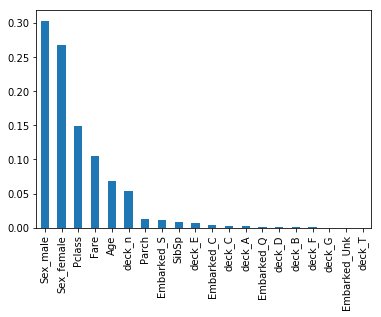

In [18]:
import matplotlib
#Get the Feature importantces for the data
%matplotlib inline
feature_imp = sorted(list(zip(list(X), rff.feature_importances_)), key=lambda x: x[1], reverse=True)
ls = pd.Series([x[1] for x in feature_imp], index=[x[0] for x in feature_imp])
ls[0:22].plot(kind='bar')

This graph agrees with my intuition. (It's also why sampling features didn't work). Sex is clearly a huge predictor, and I'd guess that a tree without it would be pretty lost. Age and proxies for wealth are next, which makes sense. (deck_n means missing, which means they were probably living near the bottom of the ship).

Anyway, I hope you enjoyed this as much as I did! Have a great one.